In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import numpy as np
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/train_tweets.csv",low_memory=False)
test = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",low_memory=False)

train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,retweet_count,text,encoded_labels
0,569264328186179584,negative,1.0,Cancelled Flight,0.6715,0,@SouthwestAir reservation (FEHQNE) 21FEB15 |...,2
1,569628431236911104,negative,1.0,Can't Tell,0.6567,0,@AmericanAir rented van drove 250 miles with 6...,2
2,567758699574226944,positive,1.0,NaN,NaN,0,@JetBlue @JayVig @roxydigital awww ^_^ R to th...,1
3,567789435795861504,negative,1.0,Customer Service Issue,1.0000,0,@united customer service 👎,2
4,569584207011434497,negative,1.0,Bad Flight,0.6442,0,@USAirways why have me board a plane knowing t...,2


In [4]:
# train.to_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/train_tweets.csv",index=False)
# test.to_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",index=False)

In [5]:
print("Here's a neutral tweet: ", train[train['airline_sentiment']=='neutral'].sample(1)['text'].values.item())
print("Here's a positive tweet: ", train[train['airline_sentiment']=='positive'].sample(1)['text'].values.item())
print("Here's a negetive tweet: ", train[train['airline_sentiment']=='negative'].sample(1)['text'].values.item())

Here's a neutral tweet:  @USAirways There is nothing on my USAir CC at this point, but the email stated I would be charged.  Thanks for the reply.
Here's a positive tweet:  @USAirways Thanks to the friendly US Airways staff that helped me get booked on various flights to get home today.  Almost there!
Here's a negetive tweet:  @united I need you to get my cousin to PDX, she's on 2 days of travel now and we've had to hire other sitters til she arrives, thx for that


In [6]:
train.isna().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  4350
negativereason_confidence       3281
retweet_count                      0
text                               0
encoded_labels                     0
dtype: int64

In [7]:
!pip install -U -q sentence-transformers
!pip install -q nltk
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 7.7 MB/s eta 0:00:00


In [8]:
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer


"""
    text pre processing pipeline. keeping it minimal since we want to leverage models
    vocabulary. We will vectorize the input text using BERT and then train a classifier
    on top of it. Before vectorizing, removing stopwords, punctuations are necessary to
    span the latent space properly.
"""

class PreProcess:
    def __init__(self,
                 model_id:str="prajjwal1/bert-small"):
        self.model_id = model_id
        self.model = SentenceTransformer(self.model_id)
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = word_tokenize


    def clean_text(self,text:str)->str:
        """
            Remove special characters, phone numbers,punctuation marks, links, and emails.
            Tokenize & Lemmatize the text
        """
        text = re.sub(r'https?://\S+|www\.\S+|<.*?>|[^A-Za-z0-9]+', ' ', text)
        text = re.sub(r'\b\d{10}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', text)
        tokens = self.tokenizer(text)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join the lemmatized tokens into a string
        cleaned_text = ' '.join(lemmatized_tokens)

        return cleaned_text

    def vectorize(self,text:str)->torch.Tensor:
        """
            Vectorizer function using the sentence transformer
            model.
        """
        return self.model.encode(text)

    def transform(self,text:str)->torch.Tensor:
        """
            The transform method, cleans the input
            text and then vectorizes it using a sentence
            transformer model.
        """
        return self.vectorize(
            self.clean_text(text)
        )


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
_process = PreProcess()

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [12]:
print("Text Before cleaning: ",train['text'][8])
print("#####################################")
print("Text after cleaning: ",
      _process.clean_text(train['text'][8]))

Text Before cleaning:  @SouthwestAir @HDsportsguy yes I did. I hope for an update soon, need those clothes for a meeting tomorrow.
#####################################
Text after cleaning:  SouthwestAir HDsportsguy yes I did I hope for an update soon need those clothes for a meeting tomorrow


In [14]:
sample_text_embedding = _process.transform(train['text'][8])
print(
    f"A sentence embedding of type {type(sample_text_embedding)} and shape {sample_text_embedding.shape} generated using BERT small model."
)

A sentence embedding of type <class 'numpy.ndarray'> and shape (512,) generated using BERT small model.


**Define a classifier head and try to train it with a custom defined parameter that'll callibrate the probablities of the output logits.**

We'll start with having two intermediate layers and one dense layer with one scaling layer to provide the final callibrated softmax probablities.

In [13]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
    def __init__(self, annotations_file):
        self.transformer = PreProcess()
        self.data = annotations_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.loc[idx, 'encoded_labels']
        text_vector = self.transformer.transform(self.data.loc[idx,'text'])
        return text_vector, label

In [15]:
from torch.utils.data import DataLoader as dataloader

train_dataloader = dataloader(
    TweetsDataset(train.reset_index(drop=True)),batch_size=16
)

test_dataloader = dataloader(
    TweetsDataset(test.reset_index(drop=True)),batch_size=8
)

In [16]:
class SentimentClassifier(torch.nn.Module):

    def __init__(self,input_embedd_dim:int,
                 num_labels:int):
        """
            A ANN impletention with dynamic
            probablity callibration during
            training
        """
        super(SentimentClassifier, self).__init__()
        self.init_scaling_factor = torch.ones(num_labels)
        self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)
        self.linear1 = torch.nn.Linear(input_embedd_dim, 200)
        self.norm1 = torch.nn.BatchNorm1d(200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, num_labels)

    def forward(self, x):
        """
            The forward pass
        """
        x = self.activation(self.norm1(
            self.linear1(x)))
        x  = self.linear2(x)/self.scaling_factor
        return x

In [23]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics import CalibrationError

loss = nn.CrossEntropyLoss()

model = SentimentClassifier(input_embedd_dim=512,
                            num_labels=train['airline_sentiment'].nunique())
optimizer = optim.Adam(model.parameters())
error = CalibrationError(num_classes=train['airline_sentiment'].nunique()
                         ,task='multiclass',norm='l1',n_bins=30)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
    Placing the model to the GPU/TPU (if available) else CPU
"""
model.to(device)

SentimentClassifier(
  (linear1): Linear(in_features=512, out_features=200, bias=True)
  (norm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=3, bias=True)
)

In [19]:
def eval_step():
    model.eval()
    test_loss, callibration_error = 0, 0
    # detach the parameter gradients
    with torch.no_grad():
        for eval_idx, eval_batch in tqdm(enumerate(test_dataloader),desc='Eval Step'):
            eval_input = eval_batch[0].to(device)
            eval_labels = eval_batch[1].to(device)
            eval_output = model(eval_input)
            # Get the loss value for the current batch
            loss_val = loss(eval_output,eval_labels)
            test_loss += loss_val.data
            #Get the callibration error for the current batch
            batch_callibration_error = error(eval_output.softmax(dim=1).detach().cpu(),eval_labels)
            callibration_error +=  batch_callibration_error
        return test_loss, callibration_error

In [25]:
model.scaling_factor.detach().cpu().numpy()

array([1., 1., 1.], dtype=float32)

In [26]:
from tqdm import tqdm

num_epochs = 15
training_loss, callib_error_train,\
 validation_loss, callib_error_test  = [], [], [], []

"""
    The training loop
"""
for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_callibration_error = 0, 0
    for idx, batch in tqdm(enumerate(train_dataloader),desc=f"Epoch {epoch}"):
        input = batch[0].to(device)
        labels = batch[1].to(device)

        """
            Training Step
        """
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(input)
        # Back Propogation Step
        loss_val = loss(output,labels)
        epoch_loss += loss_val.data
        # Calculate the callibration error
        training_batch_callibration_error = error(output.softmax(dim=1).detach().cpu(),labels)
        epoch_callibration_error +=  training_batch_callibration_error
        loss_val.backward()
        # Gradient Descent
        optimizer.step()
        # Clamp the temp value towards >1 direction (As suggested by Guo et al.)
        # classmethod for torch.nn.Parameter(1 + torch.sigmoid(model.scaling_factor) * (2 - 1),  requires_grad=True)
        model.scaling_factor.data.clamp_(min=1,max=float('Inf'))
        # break

    training_loss.append(epoch_loss)
    callib_error_train.append(epoch_callibration_error)
    print("Training loss: {}, Training Error: {}".format(epoch_loss,epoch_callibration_error))
    """
        Evaluation step
    """
    eval_loss, eval_error = eval_step()
    validation_loss.append(eval_loss)
    callib_error_test.append(eval_error)
    print("Eval loss: {}, Eval Error: {}".format(eval_loss,eval_error))
    # break

print(
    f"Training for {num_epochs} epochs done!!"
)

Epoch 0: 732it [05:19,  2.29it/s]


Training loss: 419.7391052246094, Training Error: 181.33599853515625


Eval Step: 366it [01:20,  4.57it/s]


Eval loss: 196.82138061523438, Eval Error: 93.50645446777344


Epoch 1: 732it [05:18,  2.30it/s]


Training loss: 358.4147644042969, Training Error: 162.91098022460938


Eval Step: 366it [01:20,  4.52it/s]


Eval loss: 198.80958557128906, Eval Error: 90.49810028076172


Epoch 2: 732it [05:18,  2.29it/s]


Training loss: 320.0386962890625, Training Error: 151.3896942138672


Eval Step: 366it [01:21,  4.52it/s]


Eval loss: 204.0382537841797, Eval Error: 89.86133575439453


Epoch 3: 732it [05:18,  2.30it/s]


Training loss: 281.7803039550781, Training Error: 137.63626098632812


Eval Step: 366it [01:20,  4.55it/s]


Eval loss: 211.8894500732422, Eval Error: 86.93309020996094


Epoch 4: 732it [05:18,  2.30it/s]


Training loss: 239.7069091796875, Training Error: 123.59249877929688


Eval Step: 366it [01:20,  4.54it/s]


Eval loss: 225.61892700195312, Eval Error: 86.68231201171875


Epoch 5: 732it [05:19,  2.29it/s]


Training loss: 195.02435302734375, Training Error: 107.2035903930664


Eval Step: 366it [01:20,  4.52it/s]


Eval loss: 245.6774139404297, Eval Error: 87.1642074584961


Epoch 6: 732it [05:18,  2.30it/s]


Training loss: 149.95745849609375, Training Error: 89.9942855834961


Eval Step: 366it [01:19,  4.61it/s]


Eval loss: 262.1198425292969, Eval Error: 86.25887298583984


Epoch 7: 732it [05:18,  2.30it/s]


Training loss: 107.62065887451172, Training Error: 71.13497924804688


Eval Step: 366it [01:20,  4.54it/s]


Eval loss: 289.8868408203125, Eval Error: 88.41132354736328


Epoch 8: 732it [05:18,  2.30it/s]


Training loss: 75.79692077636719, Training Error: 54.09723663330078


Eval Step: 366it [01:20,  4.53it/s]


Eval loss: 309.0802307128906, Eval Error: 85.90276336669922


Epoch 9: 732it [05:16,  2.32it/s]


Training loss: 53.27066421508789, Training Error: 40.53173828125


Eval Step: 366it [01:20,  4.53it/s]


Eval loss: 354.2969665527344, Eval Error: 87.11722564697266


Epoch 10: 732it [05:17,  2.30it/s]


Training loss: 48.7451057434082, Training Error: 36.50017547607422


Eval Step: 366it [01:20,  4.55it/s]


Eval loss: 360.3045654296875, Eval Error: 85.6412582397461


Epoch 11: 732it [05:17,  2.31it/s]


Training loss: 48.502967834472656, Training Error: 34.33008575439453


Eval Step: 366it [01:19,  4.59it/s]


Eval loss: 390.02294921875, Eval Error: 89.10669708251953


Epoch 12: 732it [05:17,  2.31it/s]


Training loss: 41.36610412597656, Training Error: 29.909683227539062


Eval Step: 366it [01:20,  4.53it/s]


Eval loss: 393.996826171875, Eval Error: 88.0288314819336


Epoch 13: 732it [05:18,  2.30it/s]


Training loss: 33.42439651489258, Training Error: 24.470443725585938


Eval Step: 366it [01:20,  4.53it/s]


Eval loss: 414.3721923828125, Eval Error: 82.79480743408203


Epoch 14: 732it [05:17,  2.30it/s]


Training loss: 28.05872917175293, Training Error: 20.162975311279297


Eval Step: 366it [01:20,  4.57it/s]

Eval loss: 430.1724853515625, Eval Error: 84.52854919433594
Training for 15 epochs done!!


In [27]:
model.scaling_factor.detach().cpu().numpy()

array([1., 1., 1.], dtype=float32)

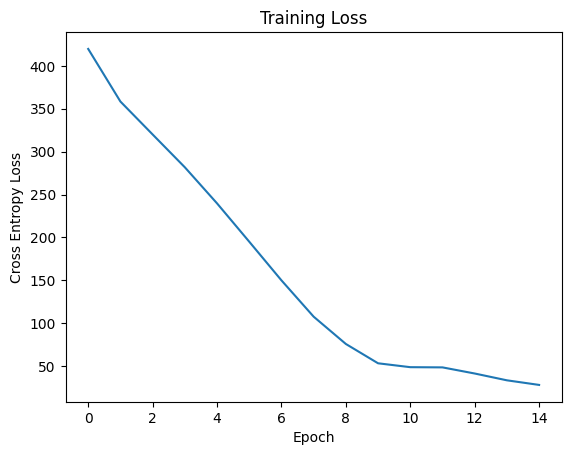

In [28]:
import matplotlib.pyplot as plt

plt.plot(training_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

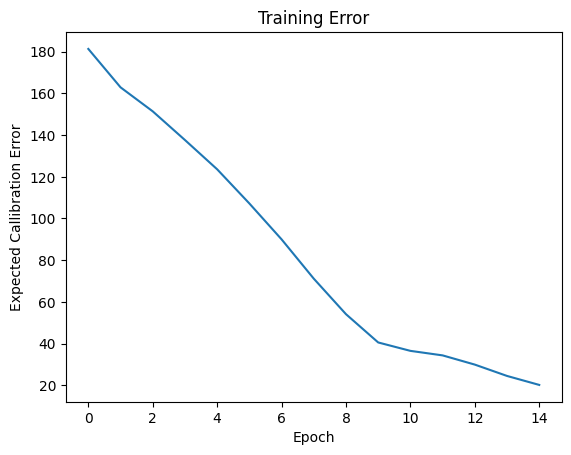

In [29]:
plt.plot(callib_error_train)
plt.xlabel('Epoch')
plt.ylabel('Expected Callibration Error')
plt.title('Training Error')
plt.show()

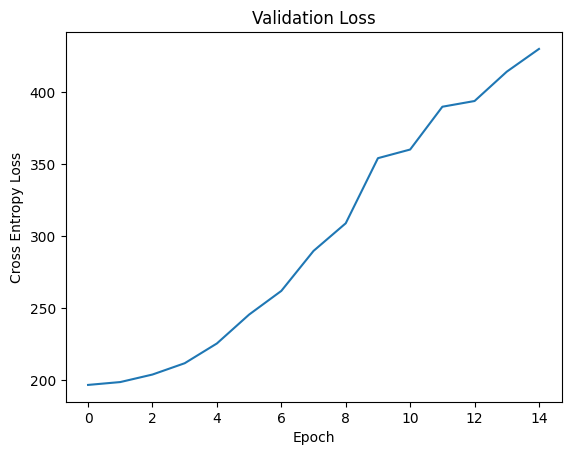

In [30]:
plt.plot(validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Validation Loss')
plt.show()

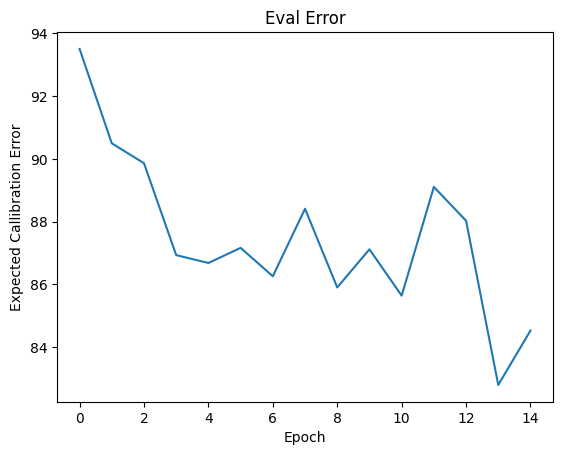

In [31]:
plt.plot(callib_error_test)
plt.xlabel('Epoch')
plt.ylabel('Expected Callibration Error')
plt.title('Eval Error')
plt.show()

In [32]:
metrics_df = pd.merge(
    pd.DataFrame({
    'Loss':training_loss,
    'ECE':callib_error_train
}).reset_index(drop=False).rename(columns={'index':'Epoch'}),
    pd.DataFrame({
    'Loss':validation_loss,
    'ECE':callib_error_test
}),
    right_index=True,left_index=True,suffixes=("_train","_eval")
)

metrics_df

,Epoch,Loss_train,ECE_train,Loss_eval,ECE_eval
0,0,tensor(419.7391),tensor(181.3360),tensor(196.8214),tensor(93.5065)
1,1,tensor(358.4148),tensor(162.9110),tensor(198.8096),tensor(90.4981)
2,2,tensor(320.0387),tensor(151.3897),tensor(204.0383),tensor(89.8613)
3,3,tensor(281.7803),tensor(137.6363),tensor(211.8895),tensor(86.9331)
4,4,tensor(239.7069),tensor(123.5925),tensor(225.6189),tensor(86.6823)
5,5,tensor(195.0244),tensor(107.2036),tensor(245.6774),tensor(87.1642)
6,6,tensor(149.9575),tensor(89.9943),tensor(262.1198),tensor(86.2589)
7,7,tensor(107.6207),tensor(71.1350),tensor(289.8868),tensor(88.4113)
8,8,tensor(75.7969),tensor(54.0972),tensor(309.0802),tensor(85.9028)
9,9,tensor(53.2707),tensor(40.5317),tensor(354.2970),tensor(87.1172)


In [33]:
path = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/Checkpoint_TweetSentimentClassifierWithoutBound.pt'

metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/TweetSentimentClassificationMetricsForTempScaledNNWithoutBound.csv',index=False)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)